In [1]:
from astropy.timeseries import LombScargle
from astropy import time
from astropy.coordinates import get_sun, EarthLocation, AltAz, solar_system_ephemeris
from astropy import units as un
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('./data/sksolartimevariation5804d.txt', skiprows=13, sep='\s+', names=['t_mean(s)', 't_mean-t_start(s)', 't_end-t_mean(s)', 'nu_flux(1e6cm-2s-1)', 'flux_up_error(1e6cm-2s-1)', 'flux_down_error(1e6cm-2s-1)'])
data

,t_mean(s),t_mean-t_start(s),t_end-t_mean(s),nu_flux(1e6cm-2s-1),flux_up_error(1e6cm-2s-1),flux_down_error(1e6cm-2s-1)
0,833654760,170100,277380,2.74,0.63,0.53
1,834127080,175500,210060,2.83,0.75,0.62
2,834550800,213180,230160,2.30,0.53,0.45
3,834997020,199380,212640,1.79,0.55,0.44
4,835380420,170520,265680,3.15,0.74,0.61
...,...,...,...,...,...,...
1338,1525315550,172739,172774,2.36,0.36,0.33
1339,1525703838,215064,215054,2.26,0.31,0.29
1340,1526138206,216970,216028,1.88,0.33,0.29
1341,1526588224,232102,226109,1.90,0.38,0.28


Divide each bin into about 5 sub-bins \
and calculate the distance in each bin and take the average\

If they are almost the same,then just calculate the distance at the mod-point\
In the end the goal is to multiply the flux provided by this distance**2\



In [2]:
def calculate_distance(date):
    # Set the observer's location on Earth (you can change these coordinates as needed)
    observer_location = EarthLocation(lat=0*un.deg, lon=0*un.deg, height=0*un.m)

    # Set the date for which you want to calculate the distance
    observation_time = time.Time(date)

    # Get the position of the Sun at the specified date
    with solar_system_ephemeris.set('builtin'):
        sun_position = get_sun(observation_time)

    # Transform the Sun's position to Altitude-Azimuth coordinates
    sun_altaz = sun_position.transform_to(AltAz(obstime=observation_time, location=observer_location))

    # Calculate the distance between the Sun and the Earth
    distance = sun_altaz.distance

    return distance

In [3]:
#convert time elapsed (in seconds) since 1st jan 1970 to dd/mm/yyyy format python

def convert_time_to_date(time_elapsed):
    return time.Time(time_elapsed, format='unix').to_datetime()


In [4]:
avg_dists_2 = []
t_mean_days = []
for i in range(len(data)):
    row = data.iloc[i]
    t_start = row['t_mean(s)'] - row['t_mean-t_start(s)']
    t_end = row['t_mean(s)'] + row['t_end-t_mean(s)']
    t_mean_days.append(convert_time_to_date(row['t_mean(s)']).strftime("%Y-%m-%d"))
    T_bins = np.linspace(t_start, t_end, 6)
    T_bins = convert_time_to_date(T_bins)
    T_bins = np.array([x.strftime("%Y-%m-%d") for x in T_bins])
    # print(T_bins)
    # dists = [calculate_distance(x) for x in T_bins]
    dists = calculate_distance(T_bins)
    # avg_dist = np.mean(dists)
    avg_dists_2.append(dists.mean().value**2)
    # print(dists)
    

In [5]:
times = data['t_mean(s)'].values * un.s
flux = data['nu_flux(1e6cm-2s-1)'].values * un.cm**-2 * un.s**-1 * 1e6
flux_err_up = data['flux_up_error(1e6cm-2s-1)'].values * un.cm**-2 * un.s**-1 * 1e6
flux_err_down = data['flux_down_error(1e6cm-2s-1)'].values * un.cm**-2 * un.s**-1 * 1e6

In [6]:
lsp = LombScargle(times, flux, dy=0.5*(flux_err_up+flux_err_down), normalization='log')
freq, power = lsp.autopower(minimum_frequency=1e-8/un.year, maximum_frequency=20/un.year)

lsp_d2 = LombScargle(times, np.multiply(flux, avg_dists_2), dy=np.multiply(0.5*(flux_err_up+flux_err_down), avg_dists_2), normalization='log')
freq_d2, power_d2 = lsp_d2.autopower(minimum_frequency=1e-8/un.year, maximum_frequency=20/un.year)

In [7]:
freq_943 = freq[np.argmin(np.abs(freq - 9.43/un.year))]
power_943 = power[np.argmin(np.abs(freq - 9.43/un.year))]

freq_d2_943 = freq_d2[np.argmin(np.abs(freq_d2 - 9.43/un.year))]
power_d2_943 = power_d2[np.argmin(np.abs(freq_d2 - 9.43/un.year))]

In [8]:
print(freq_943, power_943)

9.430504478879708 1 / yr 0.0005128729870259506


In [9]:
print(freq_d2_943, power_d2_943)

9.430504478879708 1 / yr 0.0005801569895170708


In [10]:
print(lsp.false_alarm_probability(power_943, method='bootstrap'))
print(lsp_d2.false_alarm_probability(power_d2_943, method='bootstrap'))

1.0
1.0


In [11]:
print(lsp.false_alarm_probability(power_943, method='naive'))
print(lsp_d2.false_alarm_probability(power_d2_943, method='naive'))

1.0
1.0


In [12]:
print(lsp.false_alarm_probability(power_943, method='baluev'))
print(lsp_d2.false_alarm_probability(power_d2_943, method='baluev'))

1.0
1.0


In [13]:
freq_max = freq[np.nanargmax(power)]
power_max = power[np.nanargmax(power)]

freq_d2_max = freq_d2[np.nanargmax(power_d2)]
power_d2_max = power_d2[np.nanargmax(power_d2)]

In [14]:
print(freq_max, power_max)
print(freq_d2_max, power_d2_max)

1.0650280243425922 1 / yr 0.012813376887859882
9.394093264714147 1 / yr 0.011791236844139165


In [15]:
print(lsp.false_alarm_probability(power_max, method='bootstrap'))
print(lsp_d2.false_alarm_probability(power_d2_max, method='bootstrap'))

0.891
0.986


In [16]:
print(lsp.false_alarm_probability(power_max, method='naive'))
print(lsp_d2.false_alarm_probability(power_d2_max, method='naive'))

0.4661067074807819
0.7120135954552762


In [17]:
print(lsp.false_alarm_probability(power_max, method='baluev'))
print(lsp_d2.false_alarm_probability(power_d2_max, method='baluev'))

0.8453499624335352
0.97125966438681


In [18]:
print(freq_max, freq_d2_max)

1.0650280243425922 1 / yr 9.394093264714147 1 / yr


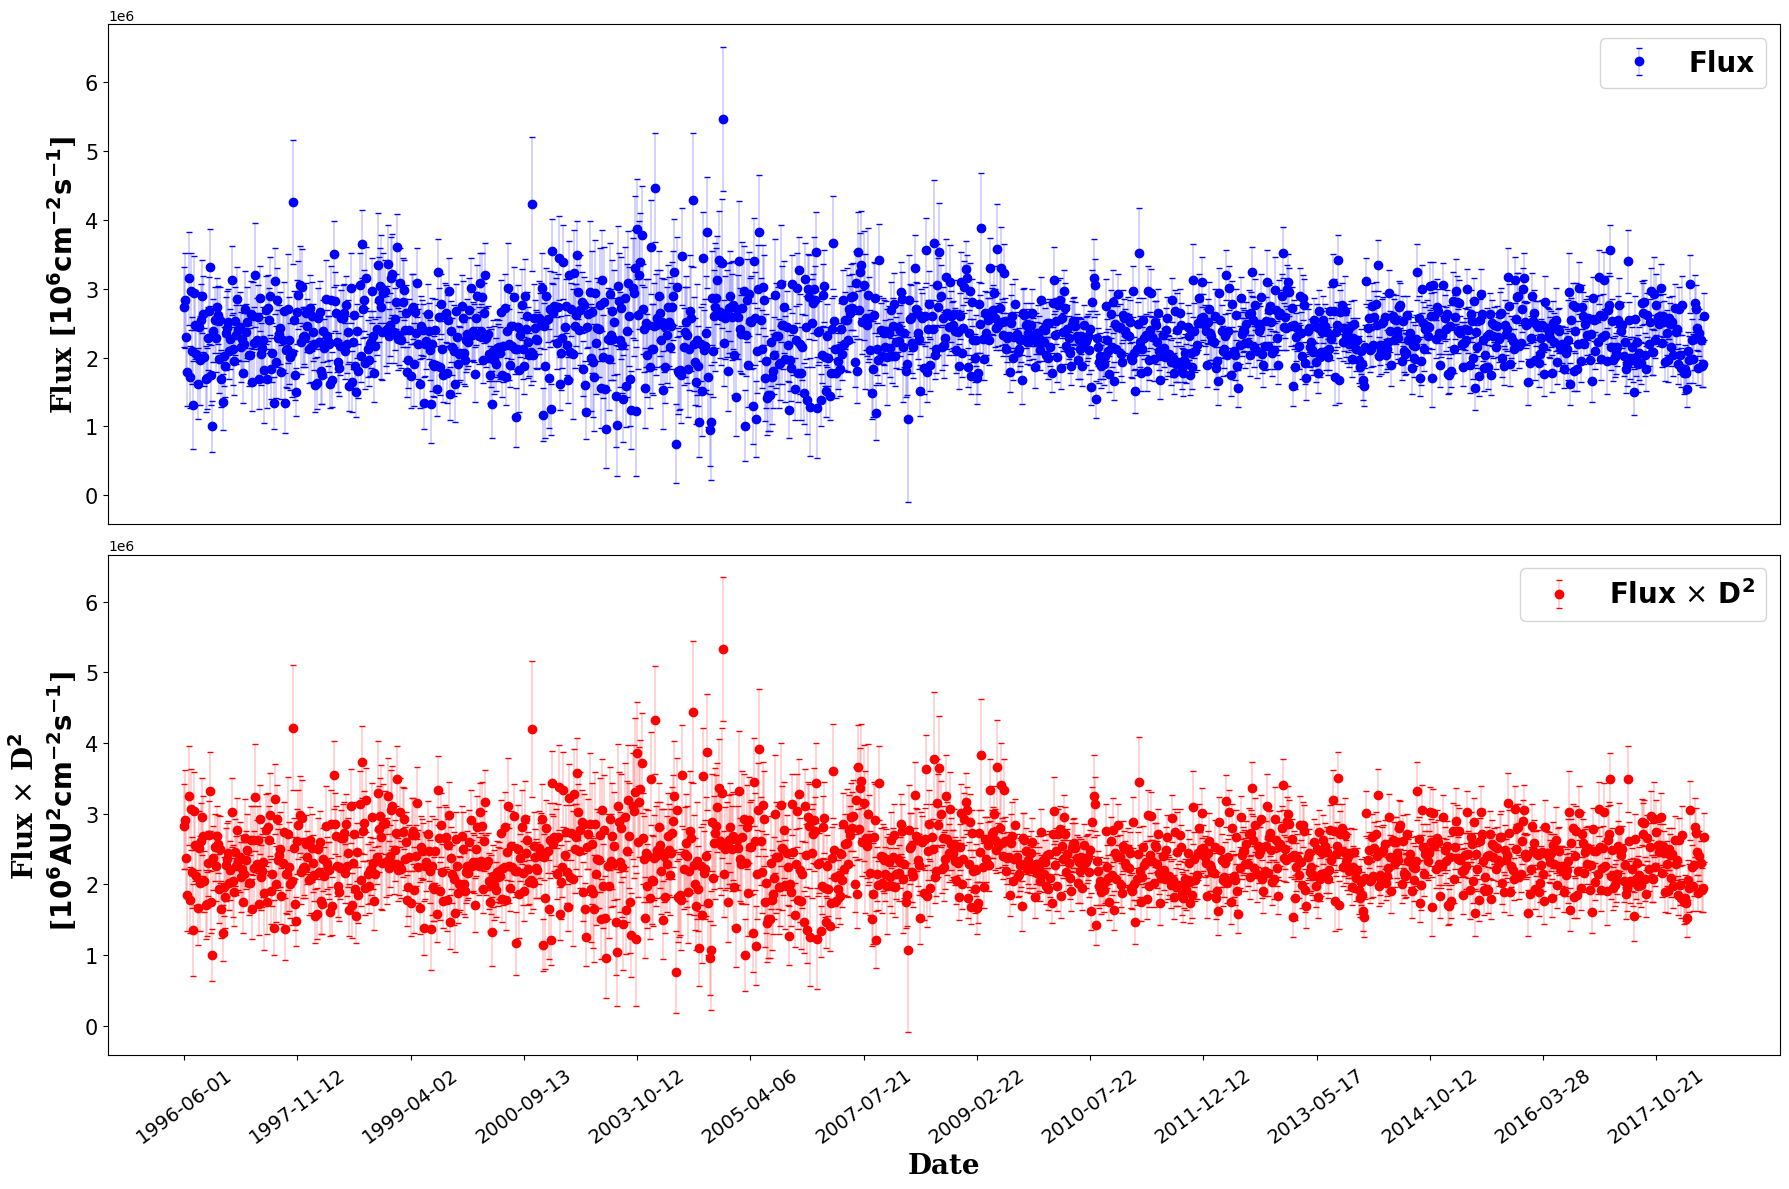

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(18, 12))

font = {'family': 'serif',
        'weight': 'bold',
        'size': 22,
        'color':  'black',
        }
smallerfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 15,
        }

axesfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 20,
        }

ax[0].errorbar(t_mean_days, flux, yerr=0.5*(flux_err_up+flux_err_down), fmt='o', c='b', elinewidth=0.24, capsize=2, label='Flux')
ax[1].errorbar(t_mean_days, np.multiply(flux, avg_dists_2), yerr=np.multiply(0.5*(flux_err_up+flux_err_down), avg_dists_2), fmt='o', c='r', elinewidth=0.24, capsize=2, label='Flux $\\times$ D$\mathbf{^2}$')

ax[0].set_ylabel('Flux [$\mathbf{10^6 cm^{-2} s^{-1}}$]', fontdict=axesfont)


ax[1].set_ylabel('Flux $\\times$ D$\mathbf{^2}$\n [$\mathbf{10^6 AU^{2} cm^{-2} s^{-1}}$]', fontdict=axesfont)

for i in range(2):
    ax[i].yaxis.set_tick_params(labelsize=15)
    ax[i].legend(prop={'size':20, 'weight':'bold'})
    
ax[0].set_xticks([])
ax[1].set_xlabel('Date',  fontdict=axesfont)
ax[1].set_xticks(t_mean_days[::100])
ax[1].xaxis.set_tick_params(labelsize=14, rotation=36)
plt.tight_layout()
plt.savefig('./outputs/timeseries.pdf')
plt.show()

In [20]:
font = {'family': 'serif',
        'weight': 'bold',
        'size': 22,
        'color':  'black',
        }
smallerfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 15,
        }

axesfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 17,
        }

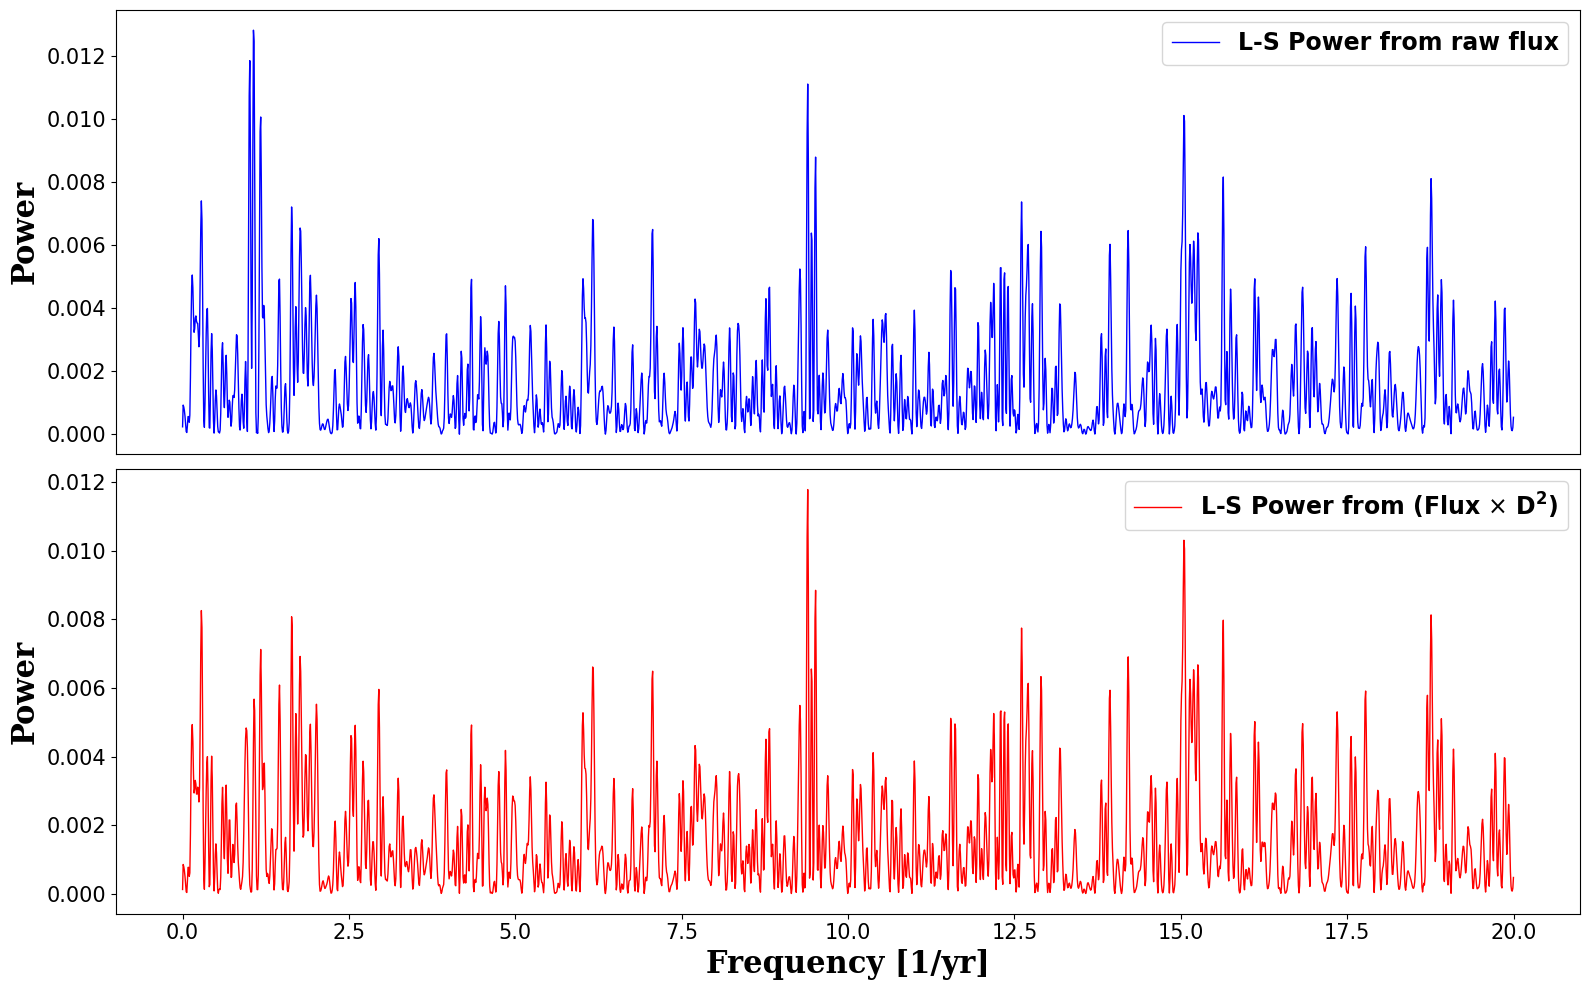

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(16, 10))

ax[0].plot(freq, power, '-', lw=1, c='b', label='L-S Power from raw flux')
# ax[0].set_title('Raw Power')
ax[1].plot(freq_d2, power_d2, '-', lw=1, c='r', label='L-S Power from (Flux $\\times$ D$\mathbf{^2}$)')
# ax[1].set_title('Power from Flux $\\times$ D^2')
for i in range(2):
    
    ax[i].set_ylabel('Power', fontdict=font)
    ax[i].yaxis.set_tick_params(labelsize=15)
    ax[i].legend(prop={'size':17, 'weight':'bold'})

ax[0].set_xticks([])
ax[1].set_xlabel('Frequency [1/yr]', fontdict=font)
ax[1].xaxis.set_tick_params(labelsize=15)
plt.tight_layout()
plt.savefig('./outputs/ls_power.pdf', format='pdf')
plt.show()

In [22]:
top_num = 20
top4_power = np.sort(power)[-top_num:]
power_ind = np.argsort(power)[-top_num:]
top4_freq = freq[power_ind]

top4_power_d2 = np.sort(power_d2)[-top_num:]
power_d2_ind = np.argsort(power_d2)[-top_num:]
top4_freq_d2 = freq_d2[power_d2_ind]

In [23]:
# print(top4_freq)
# print(top4_power)
# print(lsp.false_alarm_probability(top4_power, method='bootstrap'))
# print(lsp.false_alarm_probability(top4_power, method='naive'))
# print(lsp.false_alarm_probability(top4_power, method='baluev'))

table1 = pd.DataFrame({'Frequency [1/yr]': top4_freq, 'Power': top4_power, 'FAP (Bootstrap)': lsp.false_alarm_probability(top4_power, method='bootstrap'), 'FAP (Naive)': lsp.false_alarm_probability(top4_power, method='naive'), 'FAP (Baluev)': lsp.false_alarm_probability(top4_power, method='baluev'), 'FAP (Davies)': lsp.false_alarm_probability(top4_power, method='davies')})

In [24]:
table1

,Frequency [1/yr],Power,FAP (Bootstrap),FAP (Naive),FAP (Baluev),FAP (Davies)
0,9.503327,0.007813,1.000,1.000000,1.000000,41.498618
1,1.183364,0.008019,1.000,1.000000,1.000000,36.634328
2,18.760878,0.008105,1.000,1.000000,1.000000,34.760405
3,15.638616,0.008157,1.000,0.999999,1.000000,33.691165
4,1.083234,0.008348,1.000,0.999996,1.000000,29.982717
5,15.037831,0.008678,1.000,0.999956,1.000000,24.500976
6,9.403196,0.008741,1.000,0.999933,1.000000,23.572473
7,9.512430,0.008788,1.000,0.999911,1.000000,22.911775
8,1.019514,0.009016,1.000,0.999664,1.000000,19.916236
9,1.055925,0.009075,1.000,0.999541,1.000000,19.204482


In [25]:
table2 = pd.DataFrame({'Frequency [1/yr]': top4_freq_d2, 'Power': top4_power_d2, 'FAP (Bootstrap)': lsp_d2.false_alarm_probability(top4_power_d2, method='bootstrap'), 'FAP (Naive)': lsp_d2.false_alarm_probability(top4_power_d2, method='naive'), 'FAP (Baluev)': lsp_d2.false_alarm_probability(top4_power_d2, method='baluev'), 'FAP (Davies)': lsp_d2.false_alarm_probability(top4_power_d2, method='davies')})

In [26]:
table2

,Frequency [1/yr],Power,FAP (Bootstrap),FAP (Naive),FAP (Baluev),FAP (Davies)
0,1.174262,0.007124,1.000,1.000000,1.000000,62.839224
1,15.028729,0.007186,1.000,1.000000,1.000000,60.564353
2,15.629514,0.007237,1.000,1.000000,1.000000,58.730803
3,18.769981,0.007408,1.000,1.000000,1.000000,52.980867
4,12.607383,0.007749,1.000,1.000000,1.000000,43.140999
5,1.647607,0.007756,1.000,1.000000,1.000000,42.955152
6,0.291290,0.007757,1.000,1.000000,1.000000,42.910650
7,15.065140,0.007831,1.000,1.000000,1.000000,41.051572
8,15.638616,0.007978,1.000,1.000000,1.000000,37.533053
9,9.503327,0.008009,1.000,1.000000,1.000000,36.834905


In [27]:
table1.to_latex('./outputs/table1.tex', index=False, float_format="%.3f")
table2.to_latex('./outputs/table2.tex', index=False, float_format="%.3f")

/tmp/ipykernel_70763/713535069.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table1.to_latex('./outputs/table1.tex', index=False, float_format="%.3f")
/tmp/ipykernel_70763/713535069.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table2.to_latex('./outputs/table2.tex', index=False, float_format="%.3f")


L-S Periodogram with 2 x Coarse resolution for frequencies

In [28]:
freq_2x_coarse = np.linspace(1e-8/un.year, 20/un.year, int(10//np.diff(freq.value)[0]))
power_2x_coarse = lsp.power(freq_2x_coarse, normalization='log')

freq_d2_2x_coarse = np.linspace(1e-8/un.year, 20/un.year, int(10//np.diff(freq_d2)[0].value))
power_d2_2x_coarse = lsp_d2.power(freq_d2_2x_coarse, normalization='log')

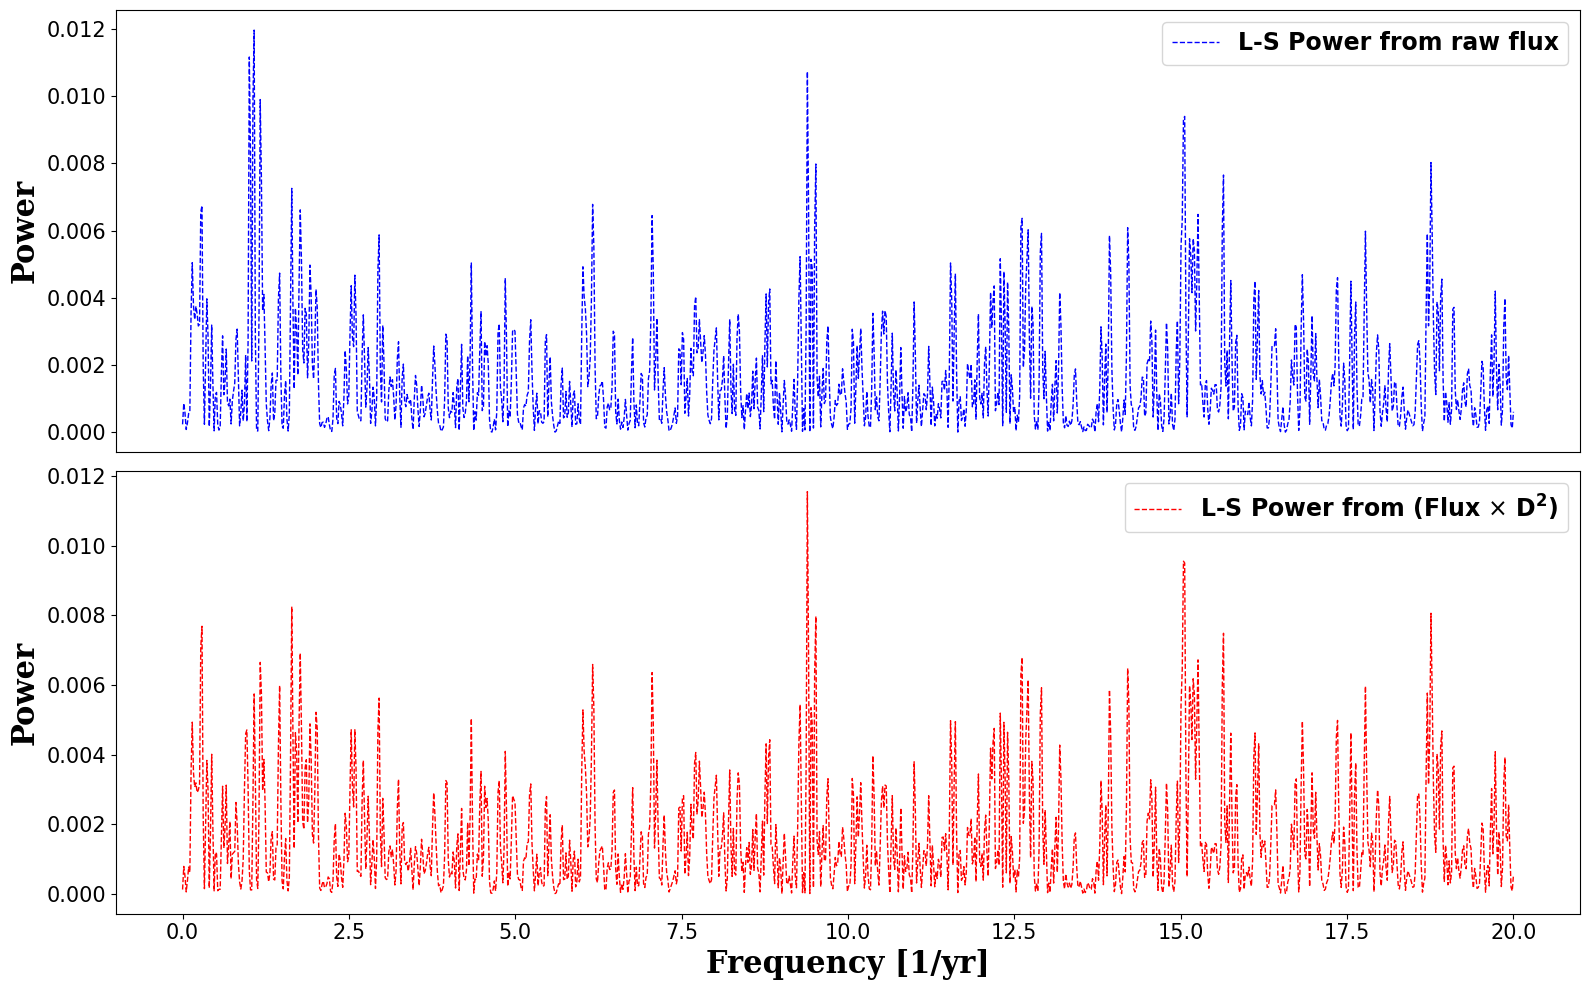

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(16, 10))

ax[0].plot(freq_2x_coarse, power_2x_coarse, '--', lw=1, c='b', label='L-S Power from raw flux')
# ax[0].set_title('Raw Power')
ax[1].plot(freq_d2_2x_coarse, power_d2_2x_coarse, '--', lw=1, c='r', label='L-S Power from (Flux $\\times$ D$\mathbf{^2}$)')
# ax[1].set_title('Power from Flux $\\times$ D^2')
for i in range(2):
    
    ax[i].set_ylabel('Power', fontdict=font)
    ax[i].yaxis.set_tick_params(labelsize=15)
    ax[i].legend(prop={'size':17, 'weight':'bold'})
    
ax[0].set_xticks([])
ax[1].set_xlabel('Frequency [1/yr]', fontdict=font)
ax[1].xaxis.set_tick_params(labelsize=15)
plt.tight_layout()
# plt.savefig('./outputs/ls_power_coarse.pdf', format='pdf')
plt.show()

In [30]:
freq_2x_coarse_max = freq_2x_coarse[np.nanargmax(power_2x_coarse)]
power_2x_coarse_max = power_2x_coarse[np.nanargmax(power_2x_coarse)]

freq_d2_2x_coarse_max = freq_d2_2x_coarse[np.nanargmax(power_d2_2x_coarse)]
power_d2_2x_coarse_max = power_d2_2x_coarse[np.nanargmax(power_d2_2x_coarse)]

In [31]:
print(freq_2x_coarse_max, power_2x_coarse_max)
print(freq_d2_2x_coarse_max, power_d2_2x_coarse_max)

1.0756609028076571 1 / yr 0.01197116579271871
9.389243396371924 1 / yr 0.011557909883281658


In [32]:
print(lsp.false_alarm_probability(power_2x_coarse_max, method='bootstrap'))
print(lsp_d2.false_alarm_probability(power_d2_2x_coarse_max, method='bootstrap'))

0.984
0.994


In [33]:
print(lsp.false_alarm_probability(power_2x_coarse_max, method='naive'))
print(lsp_d2.false_alarm_probability(power_d2_2x_coarse_max, method='naive'))

0.6682729754563828
0.7667229527610033


In [34]:
print(lsp.false_alarm_probability(power_2x_coarse_max, method='baluev'))
print(lsp_d2.false_alarm_probability(power_d2_2x_coarse_max, method='baluev'))

0.958057818177457
0.9835685473689355


In [35]:
print(lsp.false_alarm_probability(power_2x_coarse_max, method='davies'))
print(lsp_d2.false_alarm_probability(power_d2_2x_coarse_max, method='davies'))

3.1714631783883362
4.108557843553695


L-S Periodogram with custom Nyquist factor

In [36]:
print(np.diff(freq)[0], np.diff(freq_2x_coarse)[0])

0.009102803541389677 1 / yr 0.018231540556061986 1 / yr


In [37]:
# nyquist = 1/(2*np.diff(times)[0])
# nyquist = 

# freq_nyquist = np.linspace(1e-8/un.year, nyquist, int(20//np.diff(freq.value)[0]))
# power_nyquist = lsp.power(freq_nyquist, normalization='log')

# freq_d2_nyquist = np.linspace(1e-8/un.year, nyquist, int(20//np.diff(freq_d2)[0].value))
# power_d2_nyquist = lsp_d2.power(freq_d2_nyquist, normalization='log')


nyquist_factor = 1
freq_nyquist, power_nyquist = lsp.autopower(nyquist_factor=nyquist_factor)

freq_d2_nyquist, power_d2_nyquist = lsp_d2.autopower(nyquist_factor=nyquist_factor)

freq_nyquist = freq_nyquist.to(1/un.year)
freq_d2_nyquist = freq_d2_nyquist.to(1/un.year)

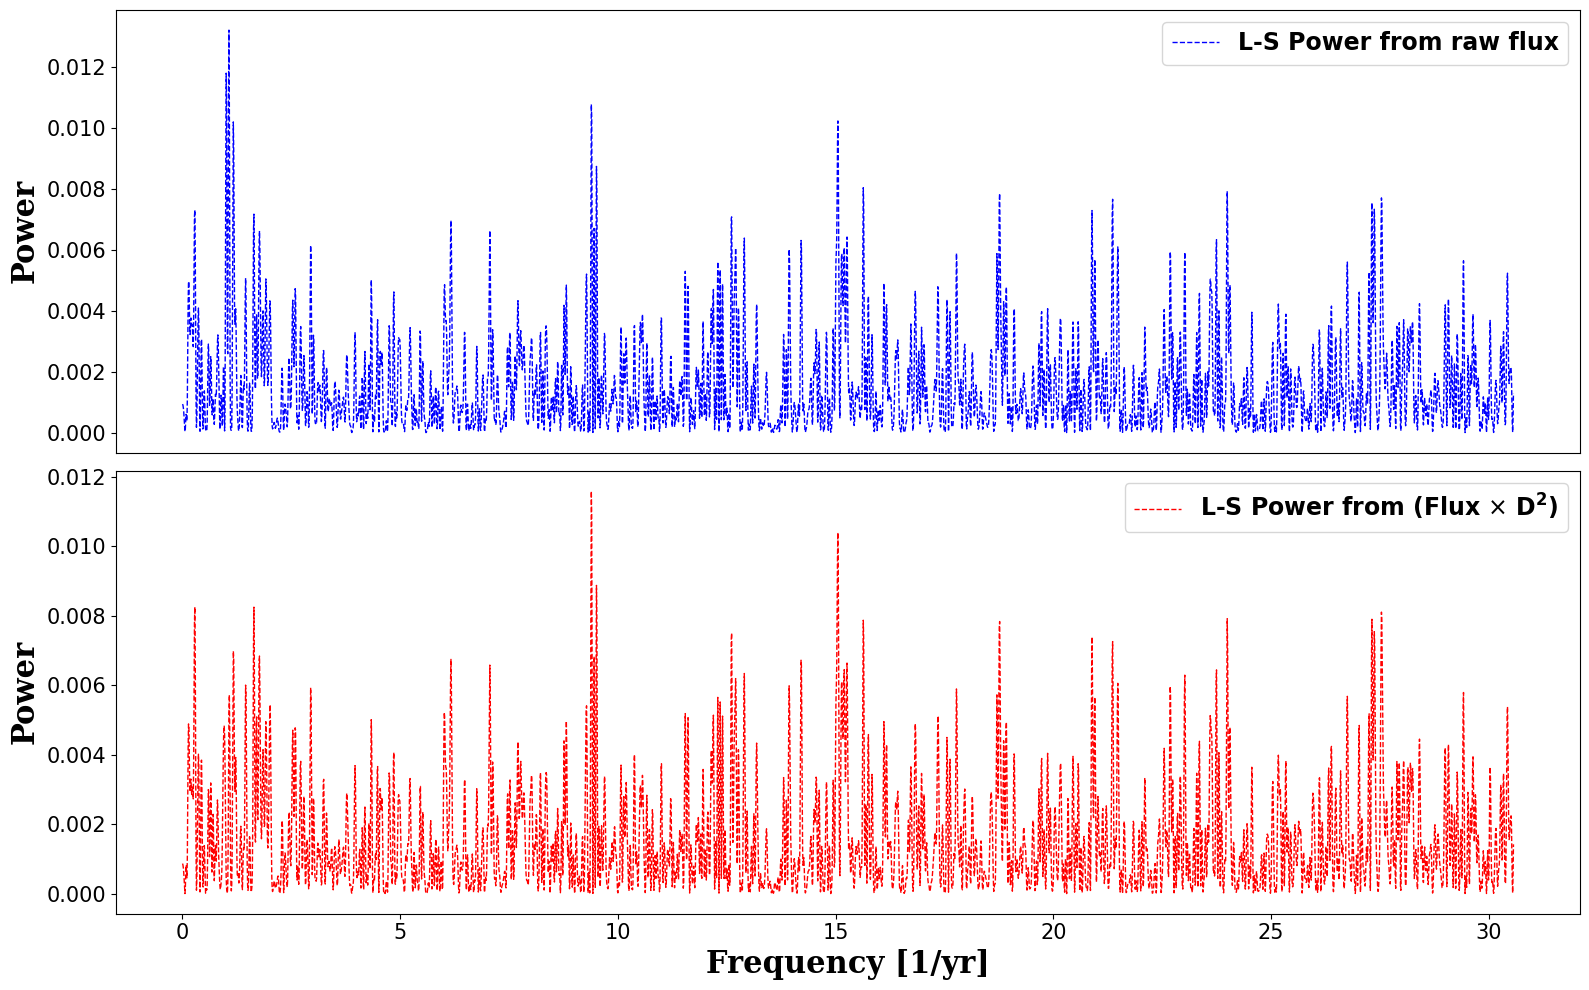

In [38]:
fig, ax = plt.subplots(2, 1, figsize=(16, 10))

ax[0].plot(freq_nyquist, power_nyquist, '--', lw=1, c='b', label='L-S Power from raw flux')
# ax[0].set_title('Raw Power')
ax[1].plot(freq_d2_nyquist, power_d2_nyquist, '--', lw=1, c='r', label='L-S Power from (Flux $\\times$ D$\mathbf{^2}$)')
# ax[1].set_title('Power from Flux $\\times$ D^2')
for i in range(2):
    
    ax[i].set_ylabel('Power', fontdict=font)
    ax[i].yaxis.set_tick_params(labelsize=15)
    ax[i].legend(prop={'size':17, 'weight':'bold'})
    
ax[0].set_xticks([])
ax[1].set_xlabel('Frequency [1/yr]', fontdict=font)
ax[1].xaxis.set_tick_params(labelsize=15)
plt.tight_layout()
# plt.savefig('./outputs/ls_power_nyquist.pdf', format='pdf')
plt.show()

In [39]:
nyquist_top_num = 10
nyquist_top4_power = np.sort(power_nyquist)[-nyquist_top_num:]
nyquist_power_ind = np.argsort(power_nyquist)[-nyquist_top_num:]
nyquist_top4_freq = freq_nyquist[nyquist_power_ind]

nyquist_top4_power_d2 = np.sort(power_d2_nyquist)[-nyquist_top_num:]
nyquist_power_d2_ind = np.argsort(power_d2_nyquist)[-nyquist_top_num:]
nyquist_top4_freq_d2 = freq_d2_nyquist[nyquist_power_d2_ind]

In [40]:
table5 = pd.DataFrame({'Frequency [1/yr]': nyquist_top4_freq, 'Power': nyquist_top4_power, 'FAP (Bootstrap)': lsp.false_alarm_probability(nyquist_top4_power, method='bootstrap'), 'FAP (Naive)': lsp.false_alarm_probability(nyquist_top4_power, method='naive'), 'FAP (Baluev)': lsp.false_alarm_probability(nyquist_top4_power, method='baluev'), 'FAP (Davies)': lsp.false_alarm_probability(nyquist_top4_power, method='davies')})

In [41]:
table6 = pd.DataFrame({'Frequency [1/yr]': nyquist_top4_freq_d2, 'Power': nyquist_top4_power_d2, 'FAP (Bootstrap)': lsp_d2.false_alarm_probability(nyquist_top4_power_d2, method='bootstrap'), 'FAP (Naive)': lsp_d2.false_alarm_probability(nyquist_top4_power_d2, method='naive'), 'FAP (Baluev)': lsp_d2.false_alarm_probability(nyquist_top4_power_d2, method='baluev'), 'FAP (Davies)': lsp_d2.false_alarm_probability(nyquist_top4_power_d2, method='davies')})

In [42]:
table5[::-1]

,Frequency [1/yr],Power,FAP (Bootstrap),FAP (Naive),FAP (Baluev),FAP (Davies)
9,1.069579,0.013214,0.853,0.381017,0.765211,1.449069
8,1.005860,0.011801,0.989,0.709607,0.970649,3.528422
7,1.060477,0.011333,0.999,0.815908,0.991186,4.731407
6,1.014963,0.010856,1.000,0.902719,0.998296,6.374660
5,9.389542,0.010780,1.000,0.913792,0.998746,6.681674
4,1.078682,0.010719,1.000,0.922223,0.999034,6.942194
3,9.398645,0.010372,1.000,0.960179,0.999819,8.617243
2,15.051486,0.010232,1.000,0.970950,0.999917,9.395867
1,1.169710,0.010200,1.000,0.973091,0.999931,9.583898
0,15.042383,0.009479,1.000,0.997157,1.000000,14.974865


In [43]:
table6[::-1]

,Frequency [1/yr],Power,FAP (Bootstrap),FAP (Naive),FAP (Baluev),FAP (Davies)
9,9.389542,0.011593,0.99,0.758793,0.982052,4.020269
8,9.398645,0.010884,1.00,0.898421,0.998093,6.262432
7,15.051486,0.010401,1.00,0.957621,0.999788,8.459919
6,15.042383,0.009706,1.00,0.993494,0.999998,13.011442
5,15.060588,0.009118,1.00,0.999431,1.000000,18.703711
4,9.507878,0.008877,1.00,0.999846,1.000000,21.683911
3,9.380439,0.008458,1.00,0.999991,1.000000,28.026847
2,0.286738,0.008258,1.00,0.999998,1.000000,31.669062
1,1.643056,0.008250,1.00,0.999998,1.000000,31.806836
0,27.531429,0.008108,1.00,1.000000,1.000000,34.695178


L-S Periodogram with default frequency grid

In [44]:
default_freq, default_power = lsp.autopower()

default_freq = default_freq.to(1/un.year)

default_freq_d2, default_power_d2 = lsp_d2.autopower()

default_freq_d2 = default_freq_d2.to(1/un.year)

default_freq_max = default_freq[np.nanargmax(default_power)]
default_power_max = default_power[np.nanargmax(default_power)]

default_freq_d2_max = default_freq_d2[np.nanargmax(default_power_d2)]
default_power_d2_max = default_power_d2[np.nanargmax(default_power_d2)]

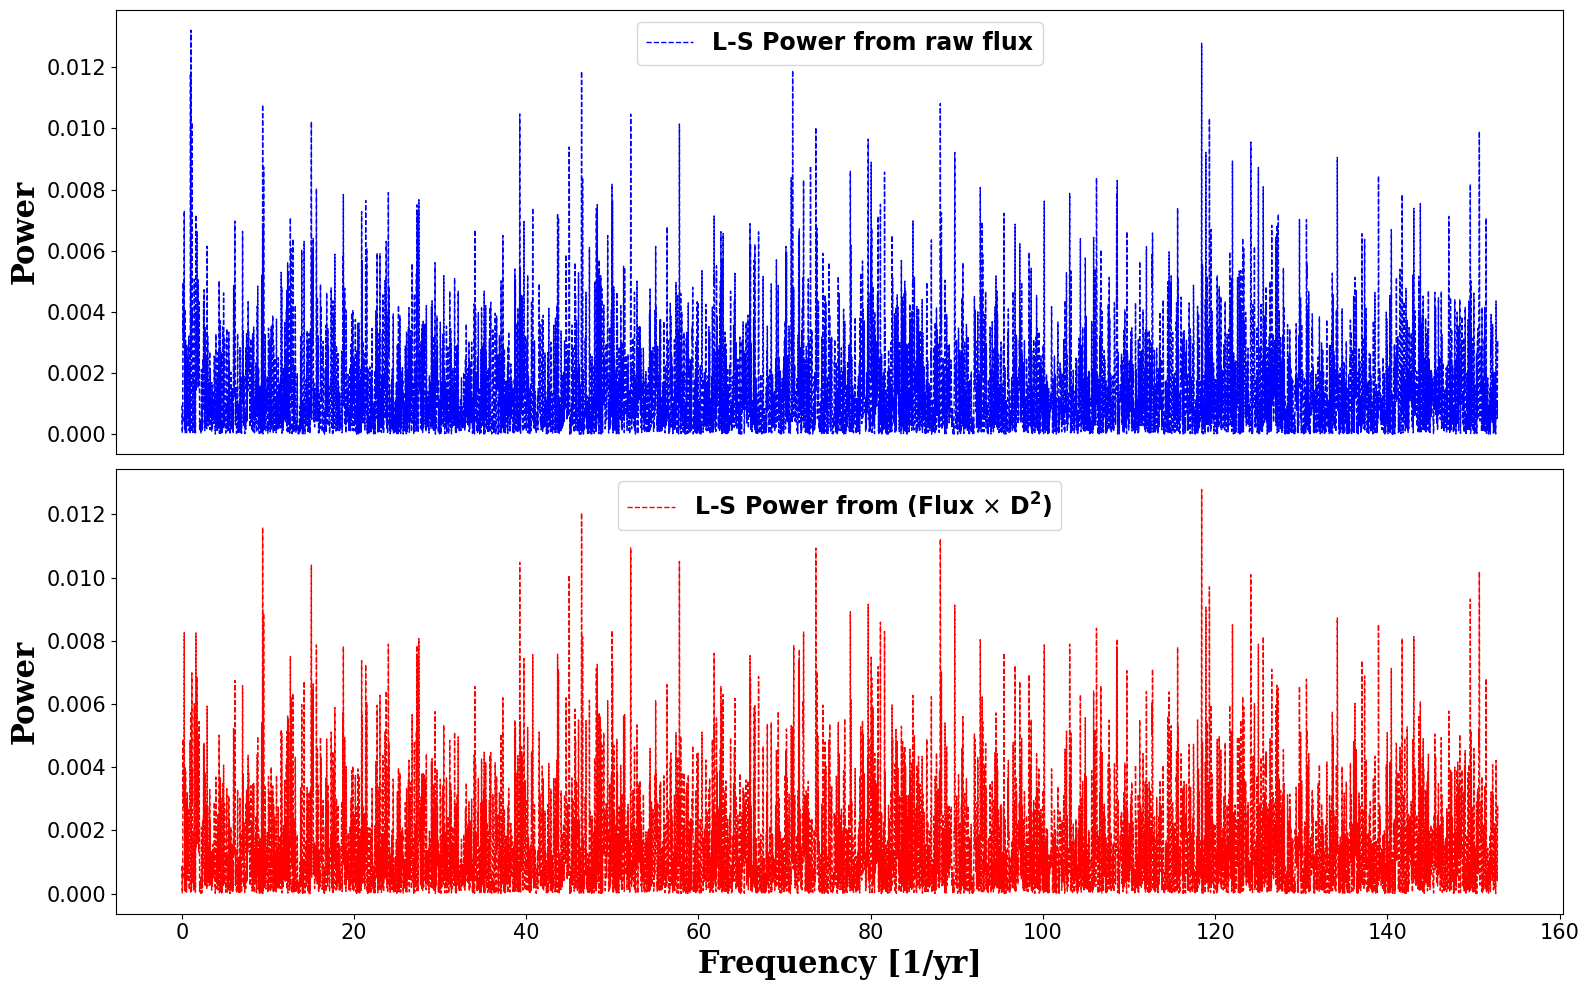

In [45]:
fig, ax = plt.subplots(2, 1, figsize=(16, 10))

ax[0].plot(default_freq, default_power, '--', lw=1, c='b', label='L-S Power from raw flux')
# ax[0].set_title('Raw Power')
ax[1].plot(default_freq_d2, default_power_d2, '--', lw=1, c='r', label='L-S Power from (Flux $\\times$ D$\mathbf{^2}$)')
# ax[1].set_title('Power from Flux $\\times$ D^2')
for i in range(2):
    
    ax[i].set_ylabel('Power', fontdict=font)
    ax[i].yaxis.set_tick_params(labelsize=15)
    ax[i].legend(prop={'size':17, 'weight':'bold'})
    
ax[0].set_xticks([])
ax[1].set_xlabel('Frequency [1/yr]', fontdict=font)
ax[1].xaxis.set_tick_params(labelsize=15)
plt.tight_layout()
# plt.savefig('./outputs/ls_power_default.pdf', format='pdf')
plt.show()

In [46]:
default_top_num = 8
default_top4_power = np.sort(default_power)[-default_top_num:]
default_power_ind = np.argsort(default_power)[-default_top_num:]
default_top4_freq = default_freq[default_power_ind]

default_top4_power_d2 = np.sort(default_power_d2)[-default_top_num:]
default_power_d2_ind = np.argsort(default_power_d2)[-default_top_num:]
default_top4_freq_d2 = default_freq_d2[default_power_d2_ind]


In [47]:
print(default_top4_freq, default_top4_freq_d2)

[  1.06047661  70.9335966    1.00585979  46.42884946  70.9426994
 118.43202548 118.44112828   1.06957942] 1 / yr [ 73.63712925  52.13630728  88.09238127  46.43795227   9.38954185
 118.43202548  46.42884946 118.44112828] 1 / yr


In [48]:
table7 = pd.DataFrame({'Frequency [1/yr]': default_top4_freq, 'Power': default_top4_power, 'FAP (Bootstrap)': lsp.false_alarm_probability(default_top4_power, method='bootstrap'), 'FAP (Naive)': lsp.false_alarm_probability(default_top4_power, method='naive'), 'FAP (Baluev)': lsp.false_alarm_probability(default_top4_power, method='baluev'), 'FAP (Davies)': lsp.false_alarm_probability(default_top4_power, method='davies')})

In [49]:
table8 = pd.DataFrame({'Frequency [1/yr]': default_top4_freq_d2, 'Power': default_top4_power_d2, 'FAP (Bootstrap)': lsp_d2.false_alarm_probability(default_top4_power_d2, method='bootstrap'), 'FAP (Naive)': lsp_d2.false_alarm_probability(default_top4_power_d2, method='naive'), 'FAP (Baluev)': lsp_d2.false_alarm_probability(default_top4_power_d2, method='baluev'), 'FAP (Davies)': lsp_d2.false_alarm_probability(default_top4_power_d2, method='davies')})

In [50]:
table7[::-1]

,Frequency [1/yr],Power,FAP (Bootstrap),FAP (Naive),FAP (Baluev),FAP (Davies)
7,1.069579,0.013214,0.844,0.381018,0.765211,1.449069
6,118.441128,0.012787,0.907,0.471941,0.850032,1.897336
5,118.432025,0.012066,0.982,0.644861,0.949580,2.987361
4,70.942699,0.011902,0.990,0.685097,0.963536,3.311418
3,46.428849,0.011868,0.990,0.693554,0.966103,3.384443
2,1.005860,0.011801,0.992,0.709608,0.970649,3.528422
1,70.933597,0.011422,0.997,0.796863,0.988597,4.473885
0,1.060477,0.011333,0.997,0.815908,0.991186,4.731407


In [51]:
table8[::-1]

,Frequency [1/yr],Power,FAP (Bootstrap),FAP (Naive),FAP (Baluev),FAP (Davies)
7,118.441128,0.012788,0.918,0.471801,0.849826,1.895958
6,46.428849,0.012050,0.980,0.648901,0.951067,3.017298
5,118.432025,0.011879,0.985,0.690723,0.965218,3.358662
4,9.389542,0.011592,0.991,0.759019,0.982096,4.022741
3,46.437952,0.011370,0.994,0.808083,0.990158,4.621098
2,88.092381,0.011226,0.996,0.837704,0.993640,5.057704
1,52.136307,0.010939,0.998,0.889588,0.997641,6.049605
0,73.637129,0.010933,0.998,0.890561,0.997694,6.072214


In [52]:
max(default_freq).to(1/un.year)

<Quantity 152.81331445 1 / yr>

In [53]:
np.diff(default_freq.to(1/un.year))[0]

<Quantity 0.0091028 1 / yr>

In [54]:
np.diff(freq)[0]

<Quantity 0.0091028 1 / yr>

LS Periodogram with max_freq =  73/year

In [55]:
freq_73, power_73 = lsp.autopower(minimum_frequency=1e-8/un.year, maximum_frequency=73/un.year)

freq_73_d2, power_73_d2 = lsp_d2.autopower(minimum_frequency=1e-8/un.year, maximum_frequency=73/un.year)

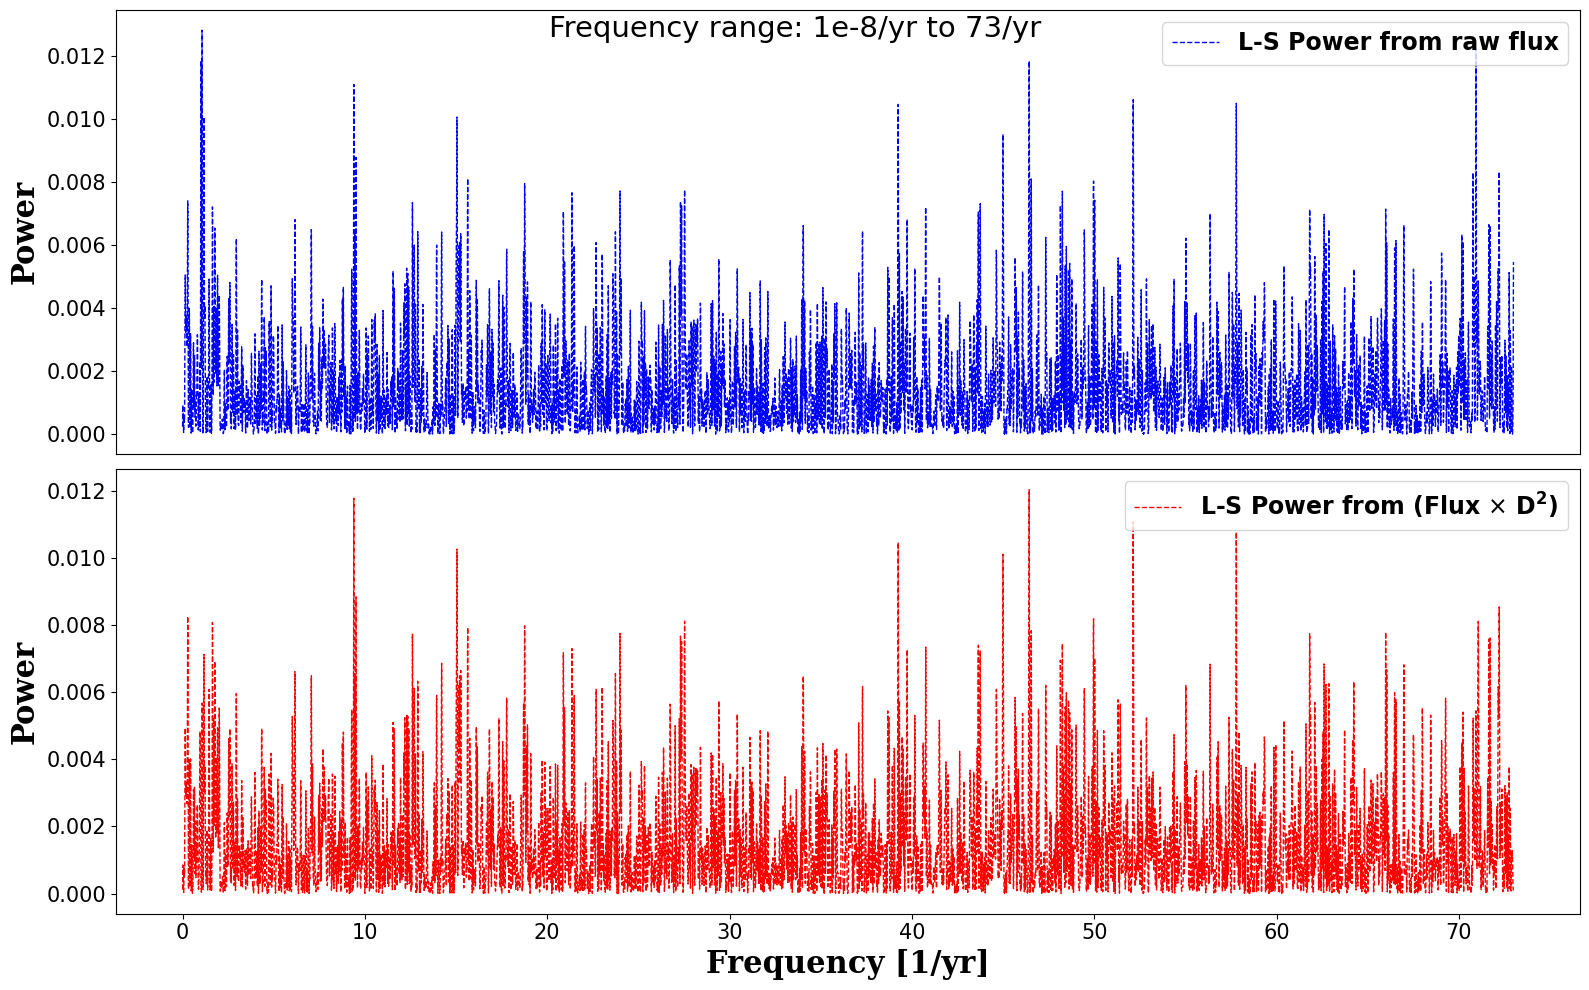

In [56]:
fig, ax = plt.subplots(2, 1, figsize=(16, 10))

ax[0].plot(freq_73, power_73, '--', lw=1, c='b', label='L-S Power from raw flux')
# ax[0].set_title('Raw Power')
ax[1].plot(freq_73_d2, power_73_d2, '--', lw=1, c='r', label='L-S Power from (Flux $\\times$ D$\mathbf{^2}$)')
# ax[1].set_title('Power from Flux $\\times$ D^2')
for i in range(2):
    
    ax[i].set_ylabel('Power', fontdict=font)
    ax[i].yaxis.set_tick_params(labelsize=15)
    ax[i].legend(prop={'size':17, 'weight':'bold'})
    
ax[0].set_xticks([])
ax[1].set_xlabel('Frequency [1/yr]', fontdict=font)
ax[1].xaxis.set_tick_params(labelsize=15)
plt.tight_layout()
plt.suptitle(f'Frequency range: 1e-8/yr to 73/yr', fontsize=21)
# plt.savefig('./outputs/ls_power_73.pdf', format='pdf')
plt.show()

In [57]:
freq_73_top_num = 10
freq_73_top4_power = np.sort(power_73)[-freq_73_top_num:]
freq_73_power_ind = np.argsort(power_73)[-freq_73_top_num:]
freq_73_top4_freq = freq_73[freq_73_power_ind]

freq_73_top4_power_d2 = np.sort(power_73_d2)[-freq_73_top_num:]
freq_73_power_d2_ind = np.argsort(power_73_d2)[-freq_73_top_num:]
freq_73_top4_freq_d2 = freq_73_d2[freq_73_power_d2_ind]

In [58]:
table9 = pd.DataFrame({'Frequency [1/yr]': freq_73_top4_freq, 'Power': freq_73_top4_power, 'FAP (Bootstrap)': lsp.false_alarm_probability(freq_73_top4_power, method='bootstrap'), 'FAP (Naive)': lsp.false_alarm_probability(freq_73_top4_power, method='naive'), 'FAP (Baluev)': lsp.false_alarm_probability(freq_73_top4_power, method='baluev'), 'FAP (Davies)': lsp.false_alarm_probability(freq_73_top4_power, method='davies')})

In [59]:
table10 = pd.DataFrame({'Frequency [1/yr]': freq_73_top4_freq_d2, 'Power': freq_73_top4_power_d2, 'FAP (Bootstrap)': lsp_d2.false_alarm_probability(freq_73_top4_power_d2, method='bootstrap'), 'FAP (Naive)': lsp_d2.false_alarm_probability(freq_73_top4_power_d2, method='naive'), 'FAP (Baluev)': lsp_d2.false_alarm_probability(freq_73_top4_power_d2, method='baluev'), 'FAP (Davies)': lsp_d2.false_alarm_probability(freq_73_top4_power_d2, method='davies')})

In [60]:
table9[::-1]

,Frequency [1/yr],Power,FAP (Bootstrap),FAP (Naive),FAP (Baluev),FAP (Davies)
9,1.065028,0.012813,0.909,0.466107,0.845350,1.866594
8,1.074131,0.012461,0.950,0.548245,0.902754,2.330506
7,70.938148,0.012213,0.969,0.608758,0.934422,2.724514
6,1.010411,0.011847,0.990,0.698482,0.967544,3.427867
5,46.433401,0.011838,0.991,0.700704,0.968180,3.447675
4,46.424298,0.011420,0.997,0.797485,0.988688,4.481926
3,70.947251,0.011130,1.000,0.856137,0.995353,5.371548
2,9.394093,0.011093,1.000,0.863068,0.995909,5.498974
1,1.001308,0.010736,1.000,0.919932,0.998960,6.868793
0,52.140859,0.010611,1.000,0.935846,0.999405,7.427320


In [61]:
table10[::-1]

,Frequency [1/yr],Power,FAP (Bootstrap),FAP (Naive),FAP (Baluev),FAP (Davies)
9,46.433401,0.012035,0.974,0.652471,0.952399,3.044909
8,9.394093,0.011778,0.981,0.715285,0.972123,3.579936
7,46.424298,0.011567,0.989,0.764703,0.983190,4.085797
6,52.140859,0.011074,0.999,0.866477,0.996159,5.562067
5,57.793700,0.010769,1.000,0.915360,0.998801,6.725953
4,39.251289,0.010463,1.000,0.951747,0.999708,8.137170
3,9.384990,0.010395,1.000,0.958096,0.999794,8.487886
2,15.046934,0.010262,1.000,0.968829,0.999901,9.219271
1,52.131756,0.010233,1.000,0.970909,0.999916,9.389208
0,46.442504,0.010206,1.000,0.972753,0.999929,9.550138
